In [0]:
from __future__ import print_function
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from IPython.display import Image

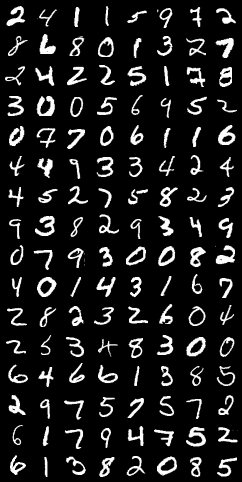

In [2]:
epochs = 10
batch_size = 128
lr = 1e-2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = datasets.MNIST('../content/data',
                               train=True,
                               download=True,
                               transform=transforms.ToTensor())

test_dataset = datasets.MNIST('../content/data',
                               train=False,
                               transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

x, _ = next(iter(train_loader))

# os.mkdir('../content/images')

save_image(x, '../content/images/train.png')

Image('../content/images/train.png')

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

model

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

In [0]:
# Reconstruction + KL
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    KLD = -.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    
    for batch_index, (data, _) in enumerate(train_loader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print('Loss: {:.4f}'.format(train_loss / len(train_loader.dataset)))
    
def test(epoch):
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                       recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                          '../content/images/reconstruction_'+ str(epoch) + '.png', nrow=n)
        
    test_loss /= len(test_loader.dataset)
    print('Test loss: {:.4f}'.format(test_loss))

In [6]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   '../content/images/sample_' + str(epoch) + '.png')

Loss: 151.9363
Test loss: 129.9761
Loss: 125.0431
Test loss: 121.0745
Loss: 120.4078
Test loss: 119.4250
Loss: 118.6334
Test loss: 117.5802
Loss: 117.8819
Test loss: 117.2195
Loss: 117.2996
Test loss: 116.2452
Loss: 116.9738
Test loss: 115.9871
Loss: 116.5561
Test loss: 115.7356
Loss: 116.3275
Test loss: 116.2212
Loss: 116.1552
Test loss: 117.1093
